In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
features_df = pd.read_csv('features-all-datasets-v2.csv')
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
1,0.257191,0.736847,0.749420,0.779179,0.760325,0.729013,0.669982,0.671527,0.696851,0.762176,...,0.012094,0.011879,0.012337,0.014288,0.015109,0.012017,0.006716,0.004248,0.002999,fear
2,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
3,0.181625,0.643610,0.581965,0.477430,0.558267,0.605189,0.522657,0.561186,0.614690,0.624254,...,0.183382,0.144932,0.060404,0.048087,0.056380,0.072826,0.076891,0.034622,0.004218,fear
4,0.290568,0.726541,0.717606,0.625811,0.651445,0.689244,0.616574,0.595777,0.650725,0.673668,...,0.203479,0.162828,0.077600,0.064426,0.074485,0.091503,0.093595,0.049453,0.020464,fear


In [5]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39909 entries, 0 to 39908
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 49.6+ MB


In [6]:
emotions_number = 8

In [7]:
X = features_df.iloc[:, :-1].values
y = features_df['labels'].values

In [8]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [9]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True)

print(
    f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

train:	 ((31927, 162), (31927, 8))
test:	((7982, 162), (7982, 8))


In [10]:
# Split once to get the test and validation set
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.3, random_state=42)
print(
    f'val:\t {x_val.shape, y_val.shape,}\ntest:\t{x_test.shape, y_test.shape}')

val:	 ((5587, 162), (5587, 8))
test:	((2395, 162), (2395, 8))


In [12]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_val = scaler.fit_transform(x_val)
# print(
#     f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_val.shape, y_val.shape}\ntest: {x_test.shape, y_test.shape}')

## Model, train


In [39]:
model = Sequential()
model.add(Conv1D(64, kernel_size=7, padding='same',
          activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(units=128, activation='relu'))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=emotions_number, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_114 (Conv1D)         (None, 162, 64)           512       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 81, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_115 (Conv1D)         (None, 81, 64)            12352     
                                                                 
 conv1d_116 (Conv1D)         (None, 81, 64)            12352     
                                                                 
 conv1d_117 (Conv1D)         (None, 81, 64)            12352     
                                                                 
 conv1d_118 (Conv1D)         (None, 81, 64)            12352     
                                                      

In [40]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)


history = model.fit(x_train, y_train, batch_size=32, epochs=100,
                    validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
998/998 [==============================] - 19s 17ms/step - loss: 1.6639 - accuracy: 0.3208 - val_loss: 1.5705 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 2/100
998/998 [==============================] - 17s 17ms/step - loss: 1.4443 - accuracy: 0.4222 - val_loss: 1.4127 - val_accuracy: 0.4296 - lr: 0.0010
Epoch 3/100
998/998 [==============================] - 17s 17ms/step - loss: 1.3229 - accuracy: 0.4715 - val_loss: 1.3229 - val_accuracy: 0.4668 - lr: 0.0010
Epoch 4/100
998/998 [==============================] - 17s 17ms/step - loss: 1.2670 - accuracy: 0.4962 - val_loss: 1.3190 - val_accuracy: 0.4589 - lr: 0.0010
Epoch 5/100
998/998 [==============================] - 17s 17ms/step - loss: 1.2160 - accuracy: 0.5143 - val_loss: 1.2440 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 6/100
998/998 [==============================] - 17s 17ms/step - loss: 1.1869 - accuracy: 0.5242 - val_loss: 1.1803 - val_accuracy: 0.5223 - lr: 0.0010
Epoch 7/100
998/998 [==============================]

In [41]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

In [42]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

 1/75 [..............................] - ETA: 2s - loss: 0.4214 - accuracy: 0.9062

75/75 [==============================] - 1s 8ms/step - loss: 0.3572 - accuracy: 0.9395
Accuracy of our model on test data :  93.94571781158447 %


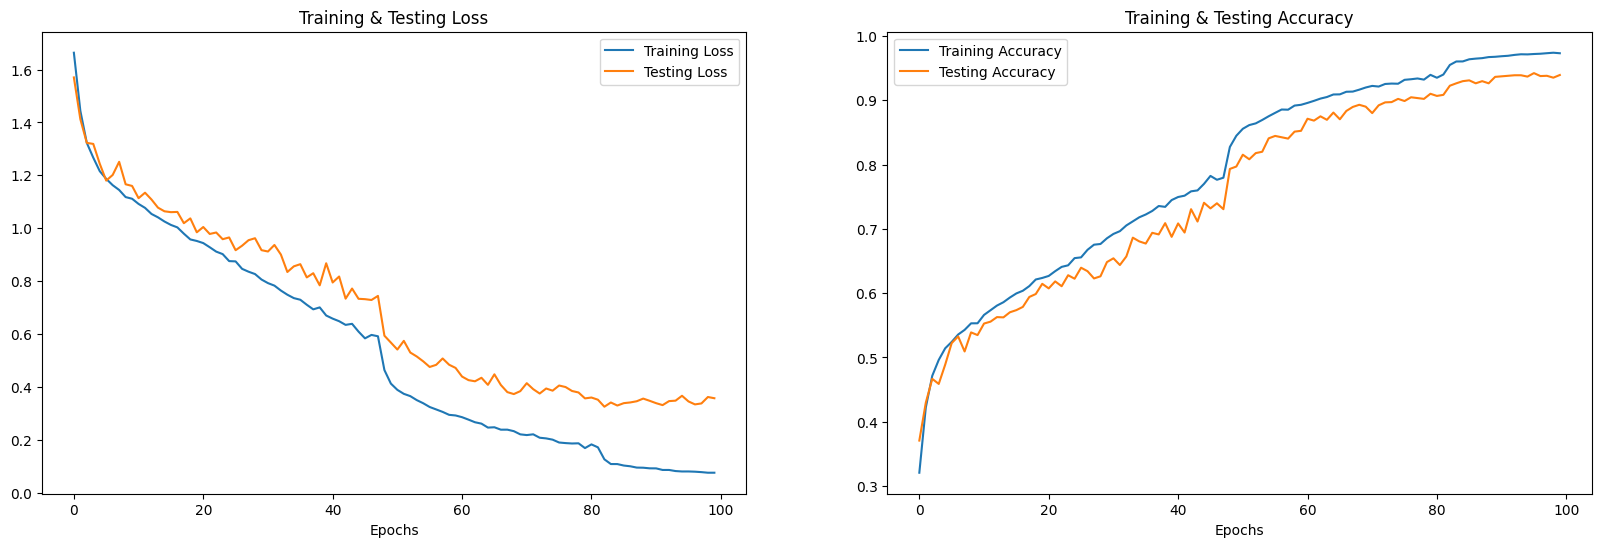

In [43]:
print_report(model, history, x_test, y_test)

In [44]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_decoded = encoder.inverse_transform(y_test)

75/75 [==============================] - 1s 6ms/step


In [45]:
# df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
# df['Predicted Labels'] = y_pred.flatten()
# df['Actual Labels'] = y_test_decoded.flatten()

# df.head(10)

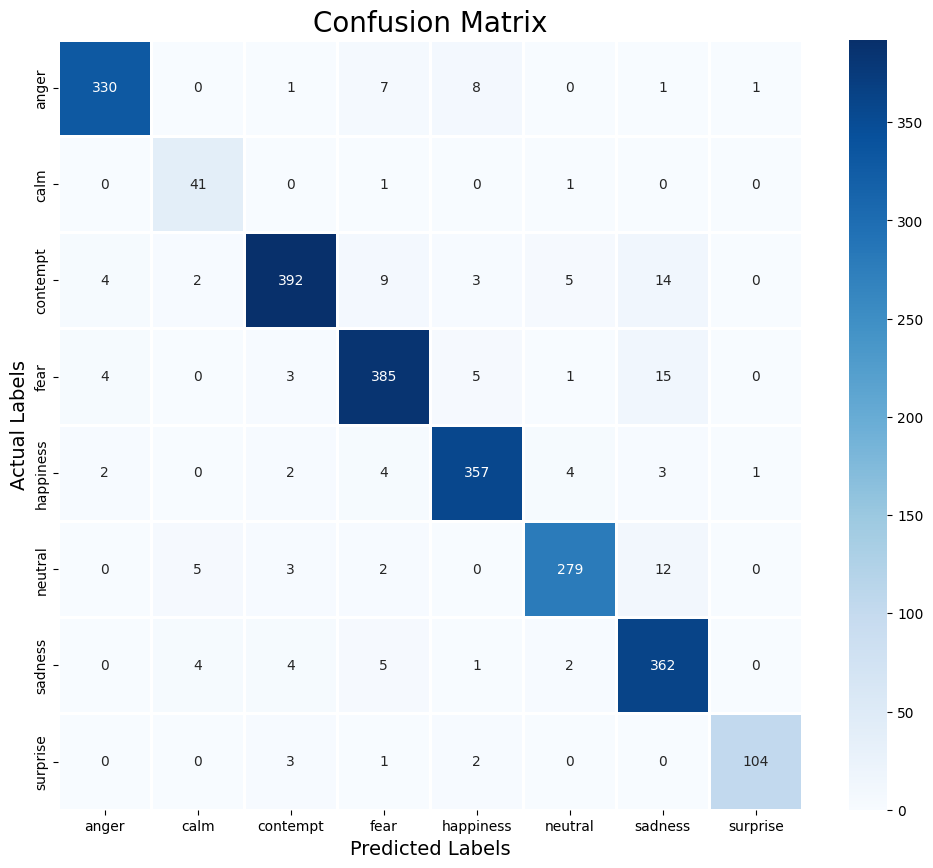

In [46]:
print_confusion_matrix(y_test_decoded, y_pred)

In [47]:
print(classification_report(y_test_decoded, y_pred))

              precision    recall  f1-score   support

       anger       0.97      0.95      0.96       348
        calm       0.79      0.95      0.86        43
    contempt       0.96      0.91      0.94       429
        fear       0.93      0.93      0.93       413
   happiness       0.95      0.96      0.95       373
     neutral       0.96      0.93      0.94       301
     sadness       0.89      0.96      0.92       378
    surprise       0.98      0.95      0.96       110

    accuracy                           0.94      2395
   macro avg       0.93      0.94      0.93      2395
weighted avg       0.94      0.94      0.94      2395



## Save model


In [48]:
model.save('ser4-v4.keras')

In [49]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model-nm-v4.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpynox_r22\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpynox_r22\assets


In [33]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Speech emotion recognition"
model_meta.description = ("Identify emotion of human voice")
model_meta.version = "v2"
model_meta.author = "Mykola Nosenko"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")  # verify later

In [34]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 8 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("./emotion_labels.txt")
label_file.description = "Labels for emotions that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [35]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
# subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [36]:
populator = _metadata.MetadataPopulator.with_model_file('./model.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["./emotion_labels.txt"])
populator.populate()

In [39]:
displayer = _metadata.MetadataDisplayer.with_model_file(
    "./model.tflite")
export_json_file = os.path.join("D:/Documents/export_models/model.json")
json_file = displayer.get_metadata_json()
# Optional: write out the metadata as a json file
with open(export_json_file, "w") as f:
    f.write(json_file)

In [31]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(
#     "./saved_models/ser4.keras")  # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('ser4-model.tflite', 'wb') as f:
#     f.write(tflite_model)